<a href="https://colab.research.google.com/github/navneetkrc/Colab_fastai/blob/master/ULMFiT_fastai_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let's install PyTorch and fastai libraries first. You have to repeat this step every time you restart this notebook in colab.

[Analytics Vidhya](https://www.analyticsvidhya.com/blog/2018/11/tutorial-text-classification-ulmfit-fastai-library/) Tutorial on which this Notebook is based on.

In [0]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
!pip install fastai

In [0]:
# import libraries
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os

In [0]:
#import dataset
from sklearn.datasets import fetch_20newsgroups
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data

In [0]:
dataset.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [0]:
# create a dataframe
df = pd.DataFrame({'label':dataset.target,
                   'text':dataset.data})

In [0]:
df.shape

(11314, 2)

In [0]:
df = df[df['label'].isin([1,10])]
df = df.reset_index(drop = True)

In [0]:
df['label'].value_counts()

10    600
1     584
Name: label, dtype: int64

In [0]:
from sklearn.model_selection import train_test_split

# split data into training and validation set
df_trn, df_val = train_test_split(df, stratify = df['label'], test_size = 0.4, random_state = 12)

In [0]:
df_trn.shape, df_val.shape

((710, 2), (474, 2))

### Preprocessing

Not needed as we do not need tokens as we are going to use the sentence embeddings and the complete sentence matters.

### Data Preparation

In [0]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")

# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn, valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32)

In [0]:
learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


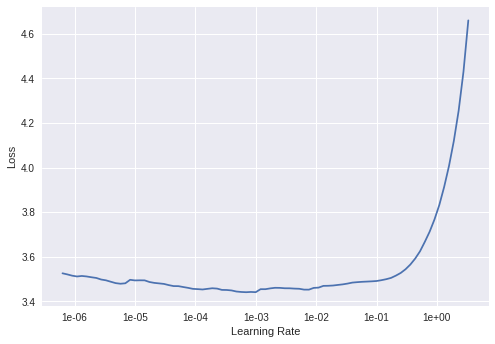

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
# train the learner object
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
1,4.981016,4.111104,0.266584,00:22
2,4.193675,3.811648,0.290856,00:22
3,3.734485,3.760023,0.296677,00:22


In [0]:
learn.save_encoder('ft_enc')

In [0]:
my_fbeta = FBeta(beta=1,average='macro')
learn.metrics = [accuracy, my_fbeta]
learn.metrics

[<function fastai.metrics.accuracy>,
 FBeta(average='macro', pos_label=1, eps=1e-09, beta=1)]

In [0]:
learn = text_classifier_learner(data_clas,arch=AWD_LSTM, drop_mult=0.7,metrics = [accuracy, my_fbeta])
learn.load_encoder('ft_enc')

[<function fastai.metrics.accuracy>,
 FBeta(average='macro', pos_label=1, eps=1e-09, beta=1)]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


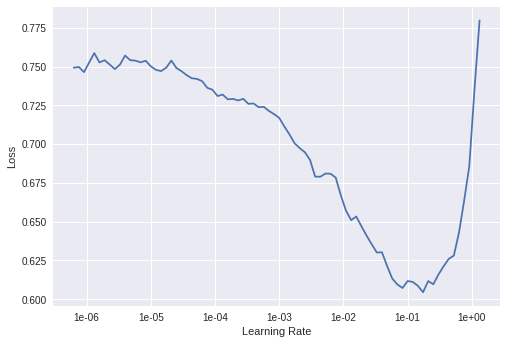

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,f_beta,time
1,0.554966,0.349806,0.835443,0.831557,01:07
2,0.508379,0.192840,0.945148,0.944956,01:07
3,0.482716,0.165374,0.951477,0.951341,01:08


In [0]:
# get predictions
preds, targets = learn.get_preds()

predictions = np.argmax(preds, axis = 1)
pd.crosstab(predictions, targets)

col_0,0,1
row_0,,
0,213,2
1,21,238


In [0]:
print("Process completed ")


Process completed 
